In [1]:
!gpustat

blade                Mon Jul  5 10:58:06 2021  455.45.01
[0] RTX A6000        | 45'C,   0 % |     0 / 48685 MB |
[1] RTX A6000        | 64'C,   0 % |     0 / 48685 MB |
[2] RTX A6000        | 43'C,   0 % |     0 / 48685 MB |
[3] RTX A6000        | 60'C,  83 % | 45770 / 48685 MB | gkissas(45767M)
[4] RTX A6000        | 39'C,   0 % |     0 / 48685 MB |
[5] RTX A6000        | 36'C,   0 % |     0 / 48685 MB |
[6] RTX A6000        | 42'C,   0 % |     0 / 48685 MB |
[7] RTX A6000        | 38'C,   2 % |     0 / 48685 MB |


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib import image


from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index



from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [4]:
from PIL import Image
import skimage

In [5]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [6]:
from helpers import *

In [7]:
class sampler:
    def __init__(self, X, Y, batch_size):

        self.X = X
        self.Y = Y
        self.batch_size = batch_size
    @partial(jit, static_argnums=(0,))
    def sample(self, key):
        idx = random.choice(key, np.arange(self.X.shape[0]), shape = (batch_size,), replace = False)
        return (self.X[idx], self.Y[idx])

In [8]:
key = random.PRNGKey(int(time.time()*100))

In [9]:
# def rgb2gray(rgb):
#     return np.dot(rgb[...,:3], np.array([0.2989, 0.5870, 0.1140]))
# file_name = 'image_regression/printed_chinese_character.jpg'
# img = image.imread(file_name)   
img = Image.fromarray(skimage.data.camera())
# Y_raw = np.array(rgb2gray(img))
Y_raw = np.array(img)
# Downsampling pictures
# Y_raw = Y_raw[::2][:,::2]
Y_raw = Y_raw.reshape(Y_raw.shape + (1,))
Y_raw.shape

(512, 512, 1)

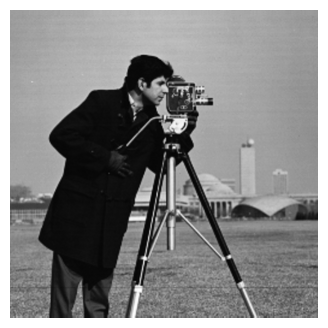

In [10]:
# change cmap for RGB image.
plt.figure(figsize = (4,4))
plt.imshow(Y_raw, cmap = 'gray')
plt.axis('off')
plt.show()
plt.close()

In [11]:
X_raw = np.array(np.meshgrid(np.arange(Y_raw.shape[0]), np.arange(Y_raw.shape[1]))).reshape(2,-1).T

In [65]:
ratio = 0.1
train_idx = random.choice(key, np.arange(X_raw.shape[0]), shape = (int(X_raw.shape[0] * ratio), ), replace = False)
X_train = X_raw[train_idx]
mu_X, sigma_X = X_train.mean(0), X_train.std(0)
X_train = (X_train - mu_X) / sigma_X
X_test = (X_raw - mu_X) / sigma_X
Y_train = Y_raw.reshape(-1,Y_raw.shape[-1])[train_idx]
mu_Y, sigma_Y = Y_train.mean(0), Y_train.std(0)
Y_train = (Y_train - mu_Y) / sigma_Y
print(f'Ratio of pixel used: {ratio}')

Ratio of pixel used: 0.1


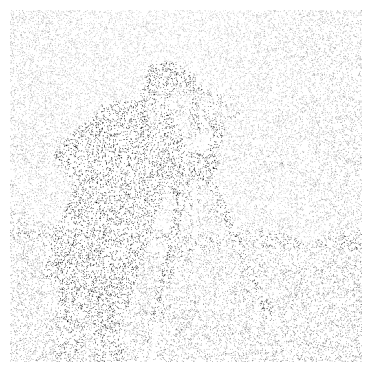

In [66]:
# Equivalent mask for training pixels.
mask = np.zeros(Y_raw.shape).reshape(-1,Y_raw.shape[-1])
mask = index_update(mask, train_idx, 1).reshape(Y_raw.shape)

plt.figure(figsize = (4, 4))
plt.imshow(Y_raw * mask/255 + (1 - mask), cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

In [67]:
layers = [X_train.shape[1], *[256 for _ in range(5)], Y_train.shape[1]]
activation = np.tanh
fit_model = MLPRegression(layers, activation = activation)

In [68]:
batch_size = 2048
data_sampler = sampler(X_train, Y_train, batch_size)

In [69]:
init_model = initNet(layers[:-1], activation = activation)
#init_model.plot_degree(init_model.scale_params, fit_model.net_params[:-1], X, word = False)

In [70]:
# Optimizers setup of pre-training
lr = 5e-3
init_fn, update_fn, get_params = optimizers.adam(lr)
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)
lam = 1e-4
@jit
def step(i, state, X):
    key = random.PRNGKey(i)
    g = grad(init_model.regulated_logSineLoss)(get_params(state), init_model.net_init(key), X, lam = lam)
    return update_fn(i, g, state)
print(f'Important: confirm lam {lam} before running!!!!!!!!!!!!!!!')

Important: confirm lam 0.0001 before running!!!!!!!!!!!!!!!


In [71]:
opt_state = init_fn(init_model.scale_params)
#nIter needs to be large enough so that the scaling parameters converges
init_nIter = 20000
pbar = trange(init_nIter)
scale_stor = []
bias_stor = []

for i in pbar:
    mini_batch = data_sampler.sample(random.PRNGKey(i))[0]
    opt_state = step(i, opt_state, mini_batch)
    
    if i % 100 == 0:
        params = get_params(opt_state)
        pbar.set_postfix({'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), mini_batch)})
        scale_stor.append([w for (w, b) in params])
        bias_stor.append([b for (w, b) in params])
        

scale_stor = np.array(scale_stor)
bias_stor = np.array(bias_stor)
        


100%|██████████| 20000/20000 [00:42<00:00, 465.98it/s, Log sine loss=0.02698496] 


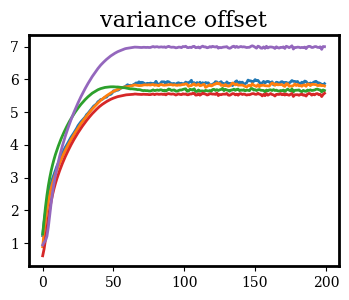

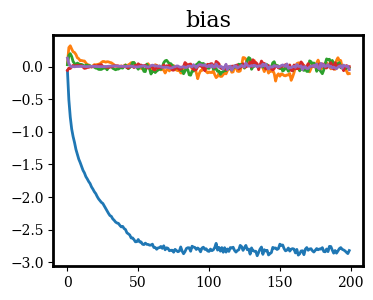

In [72]:
plt.figure(figsize = (4,3))
for i, s in enumerate(scale_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
# plt.legend()
plt.title('variance offset')
plt.show()
plt.close()

plt.figure(figsize = (4,3))
for i, s in enumerate(bias_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
# plt.legend()
plt.title('bias')
plt.show()
plt.close()

In [73]:
scale_params = params

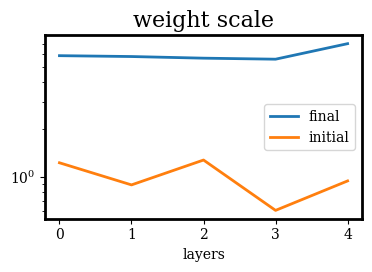

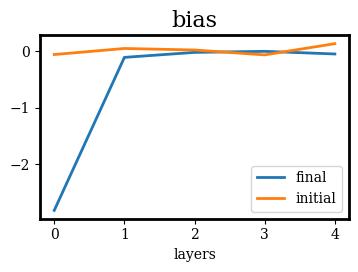

In [74]:
plt.figure(figsize = (4,3))

plt.plot([w_init for w_init, b_init in scale_params], label = 'final')
plt.plot([w_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.yscale('log')
plt.xlabel('layers')
plt.legend()
plt.title('weight scale')
plt.tight_layout()

plt.show()
plt.close()

plt.figure(figsize = (4,3))

plt.plot([b_init for w_init, b_init in scale_params], label = 'final')
plt.plot([b_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.xlabel('layers')
plt.legend()
plt.title('bias')
plt.tight_layout()

plt.show()
plt.close()

In [75]:
# Construct the scaled Xavier initialization parameter
fit_model.scaled_net_params = parameter_scaling(fit_model.net_params[:-1], scale_params) + [fit_model.net_params[-1]]

In [76]:
key = random.PRNGKey(int(time.time()*100))

In [77]:
init_fn, update_fn, get_params = optimizers.adam(optimizers.exponential_decay(1e-4, decay_steps = 2000, decay_rate = 0.99))

@jit
def step(i, state, batch):
    g = grad(fit_model.loss)(get_params(state), batch)
    return update_fn(i, g, state)

In [103]:
nIter = 200000

In [104]:
# stack the parameter trees at each leaf node for vmap
init_paramses = tree_multimap(stack_fn, fit_model.net_params, fit_model.scaled_net_params)
opt_state = vmap(init_fn)(init_paramses)
# compile the vmap optimization step
v_step = jit(vmap(step, in_axes = (None, 0, None)))

pbar = trange(nIter)


loss_stor = []

# Parallelly training from two initialization.
for i in pbar:
    mini_batch = data_sampler.sample(random.PRNGKey(i))
    opt_state = v_step(i, opt_state, mini_batch)
    if i % 1000 == 0:
        params = vmap(get_params)(opt_state)
        loss_val = vmap(fit_model.loss, in_axes = (0, None))(params, (X_train, Y_train))
        
        loss_stor.append(loss_val)
        pbar.set_postfix({'loss': loss_val})
        


100%|██████████| 200000/200000 [06:27<00:00, 515.83it/s, loss=[0.01602195 0.00066103]]


In [105]:
loss_stor = np.array(loss_stor)

opt_params = params

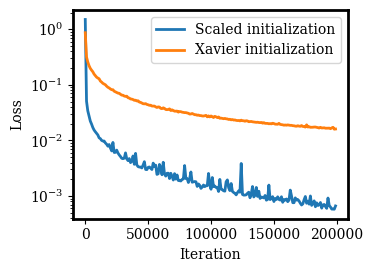

In [106]:
plt.figure(figsize = (4,3))
plt.plot(1000 * np.arange(loss_stor.shape[0]), loss_stor[:, 1], label = 'Scaled initialization')
plt.plot(1000 * np.arange(loss_stor.shape[0]), loss_stor[:, 0], label = 'Xavier initialization')
plt.yscale('log')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()
plt.close()

In [107]:
print(vmap(fit_model.l2_error, in_axes = (0, None))(opt_params, (X_train, Y_train)))

[0.12657785 0.02571054]


In [108]:
# extract individual parameter tree from the stacked tree
normal_opt_params = tree_map(lambda x: x[0], opt_params)
scaled_opt_params = tree_map(lambda x: x[1], opt_params)

In [109]:
normal_pred_img = (fit_model.net_apply(normal_opt_params, X_test) * sigma_Y + mu_Y).reshape(Y_raw.shape)
scaled_pred_img = (fit_model.net_apply(scaled_opt_params, X_test) * sigma_Y + mu_Y).reshape(Y_raw.shape)

In [110]:
normal_pred_img.min()

DeviceArray(-83.13395, dtype=float32)

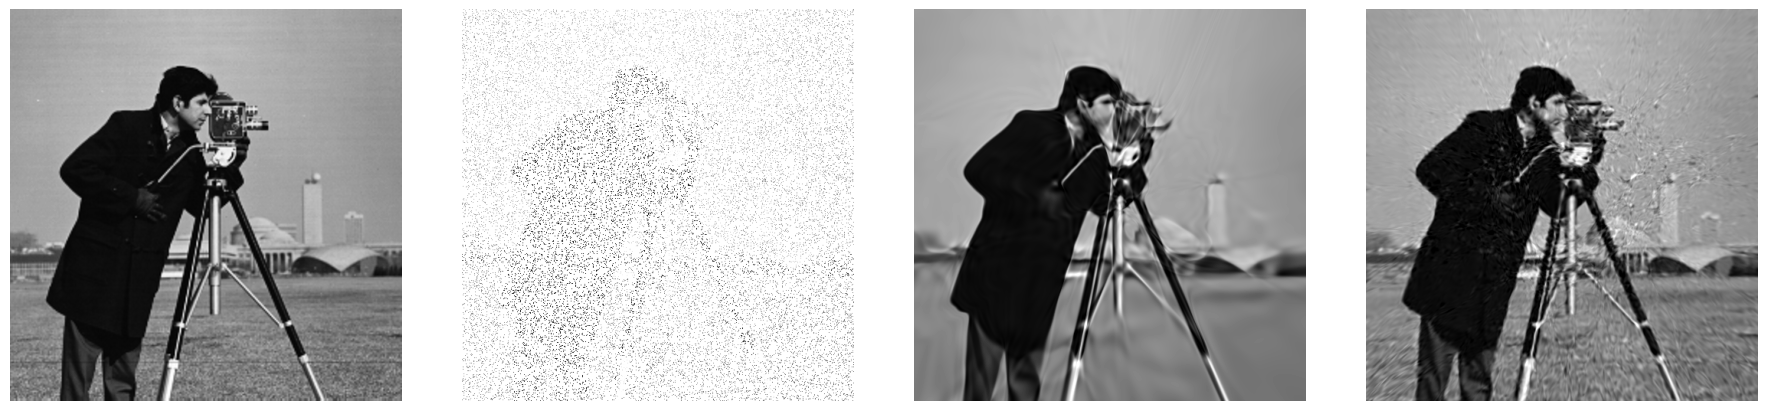

In [111]:
plt.figure(figsize = (18, 5))
plt.subplot(1,4,1)
plt.imshow(Y_raw/255, cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(1,4,2)
plt.imshow((mask * Y_raw)/255 + 1 - mask, cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(1,4,3)
plt.imshow(np.clip(normal_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(1,4,4)
plt.imshow(np.clip(scaled_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.tight_layout()
plt.axis('off')

# plt.savefig(file_name[:-4] + f'_train_result_{batch_size}_{ratio}_gray.pdf', dpi = 300)

plt.show()
plt.close()